# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [3]:
import tensorflow as tf
import copy
import torch.nn.functional as F
from keras.datasets import cifar10
import random
import warnings
import torch.nn as nn
import torchvision
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.manifold import TSNE
from torch import linalg as LA

2022-07-21 02:17:32.286811: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-21 02:17:32.336823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-21 02:17:32.336850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
warnings.filterwarnings('ignore')

## Device

Set device to work with (GPU or CPU)

In [5]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# ******

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

train_subset, val_subset = torch.utils.data.random_split(
        trainset, [42500, 7500], generator=torch.Generator().manual_seed(1))

trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=128, shuffle=True, num_workers=1)

validloader = torch.utils.data.DataLoader(
    val_subset, batch_size=128, shuffle=True, num_workers=1)

# ******


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

# ******

X_train = np.array(trainset.data)
y_train = np.array(trainset.targets)
X_test = np.array(testset.data)
y_test = np.array(testset.targets)

Files already downloaded and verified
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [9]:
num_classes = len(classes)
samples_per_class = 5
for y, label in enumerate(classes):
    in_class_ids = np.flatnonzero(y_train == y)
    in_class_ids = np.random.choice(in_class_ids, samples_per_class, replace=False)
    for i, idx in enumerate(in_class_ids):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(label)
plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_len, out_len, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_len, out_len, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_len)
        self.conv2 = nn.Conv2d(out_len, out_len, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_len)
        
        layers = []
        if stride != 1 or in_len != out_len:
            layers.append(nn.Conv2d(in_len, out_len, kernel_size=1, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_len))
            self.shortcut = nn.Sequential(*layers)

        else:
            self.shortcut = nn.Sequential()
        

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.bn2(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
                
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )
        
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512, stride=1)
        )
        
        self.linear = nn.Linear(512, 10)

    def create_block(self, out_len, stride):
        layers = []
        layers.append(ResidualBlock(self.in_len, out_len, stride=stride))
        self.in_len = out_len
        layers.append(ResidualBlock(self.in_len, out_len, stride=1))
        return nn.Sequential(*layers)
    
    def get_feature_space(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out
    
    def forward(self, x):
        out = self.get_feature_space(x)
        out = self.linear(out)
        return out

### Model instantiation

Create an instance of your model and move it to `device`

In [10]:
model = ResNet18()
model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## Train

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000125)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [27]:
def pre_epoch(step, model):
    if step == 'train':
        model.train()
    elif step == 'validation':
        model.eval()
    else:
        raise 'Wrong Step'
        
torch.cuda.empty_cache()

num_epochs = 50

val_acc_history = []
train_acc_history = []
val_loss_history = []
train_loss_history = []

torch.cuda.empty_cache()
best_accuracy = 0.0
steps = ['train', 'validation']
dataloaders = {
    'validation': validloader,
    'train': trainloader
}

print('number of epochs = {}'.format(num_epochs))
print('*********************')
for epoch in range(num_epochs):
    print('epoch = {}'.format(epoch))
    for step in steps: 
        print('step = {}'.format(step))
        pre_epoch(step, model)
        loss = 0.0
        correct_number = 0

        for data, targets in dataloaders[step]: 
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(step == 'train'):
                outputs = model(data)
                loss = criterion(outputs, targets)
                _, preds = torch.max(outputs, 1)
                if step == 'train': 
                    loss.backward()
                    optimizer.step()
                    
            loss += loss.item() * data.size(0)
            correct_number += torch.sum(preds == targets.data)

        if step == 'validation':
            lr_scheduler.step()
            
        epoch_loss = loss / len(dataloaders[step].dataset)
        epoch_accuracy = correct_number.double() / len(dataloaders[step].dataset)


        if step == 'validation':
            if epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                torch.save(model.state_dict(), 'cifar10-resnet18.pth')
            val_acc_history.append(epoch_accuracy)
            val_loss_history.append(epoch_loss)               
            
        if step == 'train':
            train_acc_history.append(epoch_accuracy)
            train_loss_history.append(epoch_loss)
        
        print('loss = {:.4f} accuracy = {:.4f}'.format(epoch_loss, epoch_accuracy))

    print('*********************')

val_acc_history = [x.item() for x in val_acc_history]
train_acc_history = [x.item() for x in train_acc_history]
val_loss_history = [x.item() for x in val_loss_history]
train_loss_history = [x.item() for x in train_loss_history]

number of epochs = 50
*********************
epoch = 0
step = train
loss = 1.4612 accuracy = 0.4664
step = validation
loss = 1.3753 accuracy = 0.5316
*********************
epoch = 1
step = train
loss = 0.9905 accuracy = 0.6465
step = validation
loss = 1.0128 accuracy = 0.6465
*********************
epoch = 2
step = train
loss = 0.7906 accuracy = 0.7242
step = validation
loss = 0.9276 accuracy = 0.6905
*********************
epoch = 3
step = train
loss = 0.6552 accuracy = 0.7696
step = validation
loss = 0.7572 accuracy = 0.7447
*********************
epoch = 4
step = train
loss = 0.5637 accuracy = 0.8035
step = validation
loss = 0.7429 accuracy = 0.7499
*********************
epoch = 5
step = train
loss = 0.5408 accuracy = 0.8136
step = validation
loss = 0.9839 accuracy = 0.7084
*********************
epoch = 6
step = train
loss = 0.5055 accuracy = 0.8258
step = validation
loss = 0.5318 accuracy = 0.8165
*********************
epoch = 7
step = train
loss = 0.4248 accuracy = 0.8530
step = valid

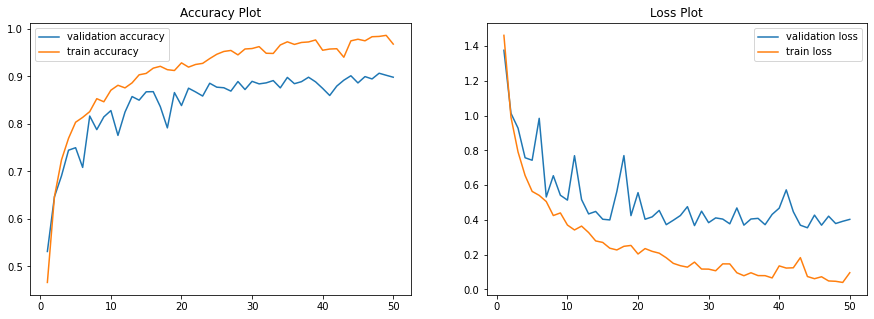

In [23]:
xs = [i+1 for i in range(num_epochs)]
figure, axis = plt.subplots(1, 2, figsize=(15,5))

axis[0].plot(xs, val_acc_history)
axis[0].plot(xs, train_acc_history)
axis[0].legend(['validation accuracy', 'train accuracy'])
axis[0].set_title("Accuracy Plot")
axis[1].plot(xs, val_loss_history)
axis[1].plot(xs, train_loss_history)
axis[1].legend(['validation loss', 'train loss'])
axis[1].set_title("Loss Plot")

plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [29]:
test_loss = 0.0
correct_number = 0

model = ResNet18()
model.load_state_dict(torch.load('./cifar10-resnet18.pth'))
model.to(device)
model.eval()

for _, (data, target) in enumerate(testloader): 
  data, target = data.to(device), target.to(device)
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)    
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not device == 'cuda' else np.squeeze(correct_tensor.cpu().numpy())
  correct_number += correct.sum() 


test_loss = test_loss / len(testloader.dataset)
total_accuraty = 100. * correct_number / len(testloader.dataset)
print('loss = {:.4f}'.format(test_loss))
print('accuracy = {:.4f}%'.format(total_accuraty))

loss = 0.3917
accuracy = 90.7100%


In [32]:
# for lack of resource we switch to cpu
device = 'cpu' 

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

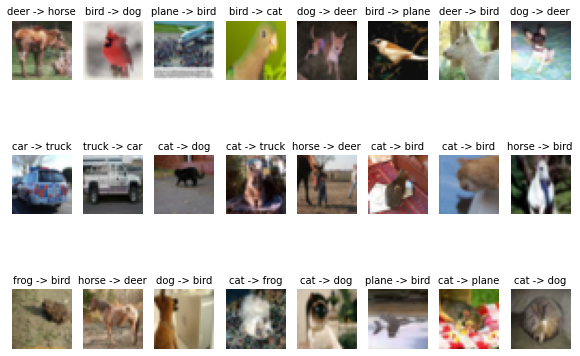

In [33]:
model.to(device)
counter = 0
miss_predicted = []
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(10,7))
for batch_id, (data, target) in enumerate(testloader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct =  np.squeeze(correct_tensor.cpu().numpy())
  pred_list = pred.cpu().numpy()
  target_list = target.cpu().numpy()
  for p_id, pred_correct in enumerate(correct):
        if not pred_correct:
            counter += 1
            miss_predicted.append([target_list[p_id], pred_list[p_id], X_test[batch_id * 100 + p_id]])
  if counter >= 200:
    break
        
np.random.shuffle(miss_predicted)
miss_predicted = miss_predicted[:24]
counter = 0

for col in axes:
    for row in col:
        row.imshow(miss_predicted[counter][2].astype('uint8'))
        title = '{tl} -> {pl}'.format(tl=classes[miss_predicted[counter][0]], pl=classes[miss_predicted[counter][1]])
        row.set_title(title, fontsize=10)
        row.axis('off')
        counter += 1

plt.show()
        

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [34]:
alltrainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=False, num_workers=1)

model.eval()
arr = []
for i, (data, target) in enumerate(alltrainloader):
    output = model.get_feature_space(data.to(device))
    output = output.detach().numpy()
    for out in output:
        arr += [list(out)]

feature_space = torch.FloatTensor(arr)
print(feature_space.shape)

torch.Size([50000, 512])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

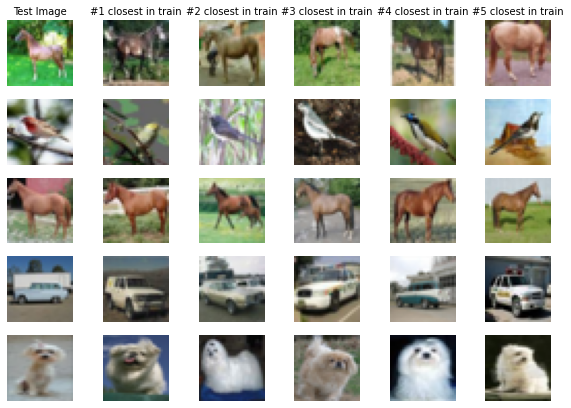

In [35]:
def get_k_nearest(feature, f_space):
    diff = torch.sub(f_space, feature) 
    norms = LA.norm(diff, dim=1)
    nearests = torch.topk(norms, 6, largest=False)
    return nearests.indices[1:]

indices = torch.randperm(50000)[:5]
features = feature_space[indices]
nearests_index = [[] for i in range(5)]
for i, feature in enumerate(features):
    nearests_index[i].append(get_k_nearest(feature, feature_space))

images = [[X_train[i.item()]] for i in indices]
for j, group in enumerate(nearests_index):
    for index in group[0]:
        images[j].append(X_train[index.item()])
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(10,7))
cols = ['Test Image' if i == 0 else '#{n} closest in train'.format(n=i) for i in range(6)]
for i, col in enumerate(axes):
    for j, row in enumerate(col):
        row.imshow(images[i][j].astype('uint8'))
        row.axis('off')
        
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.show()

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [36]:
indices = torch.randperm(50000)[:2000]
samples = feature_space[indices]
output = model.linear(samples)
_, pred = torch.max(output, 1)
pred = pred.numpy()
samples_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(samples.numpy())
samples_embedded.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

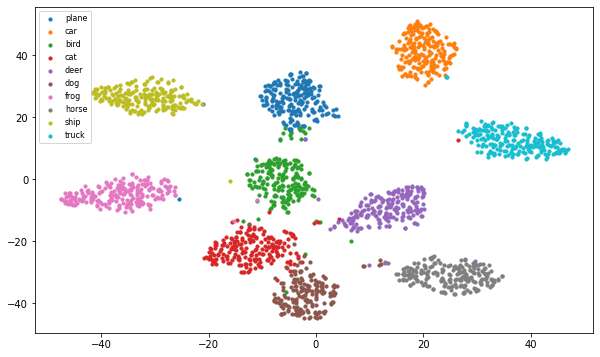

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
zipped = list(zip(samples_embedded, pred))
for i, label in enumerate(classes):
    data = np.array([x[0] for x in zipped if x[1] == i])
    ax.scatter(data[:,0], data[:, 1], c=colors[i], s=10, label=label)
ax.legend(prop={'size': 8})
plt.show()